Modèle additif, on essaie de capter la composante saisonniere avec une spline cyclique.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [12]:
def fct_scores_mse(Y_true, Y_pred, liste_stations):
    
    Y_true = Y_true.sort_values(by = ["Date"])
    Y_pred = Y_pred.sort_values(by = ["Date"])
    
    liste_mse = []
    for code in liste_stations:
        liste_mse.append(np.mean(np.square(Y_true[code] - Y_pred[code])))
    resultat = pd.DataFrame({"Code station": liste_stations, "MSE": liste_mse})
    return resultat

In [4]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

## Fonctions

### Calcul de la spline

In [16]:
def fct_Modele_Spline_fit(mesures_train, liste_stations, n_knots):
    ## Fonction pour déterminer les splines cycliques
    # mesures: dataframe X d'entrainement
    # n_knots: le nombre de noeuds
    
    mesures_stations = mesures_train[["Date"] + liste_stations]
    # On moyenne sur les années présentes dans l'ensemble d'entrainement
    mesures_moyennes = pd.DataFrame()
    for curr_mois in range(1, 13):
        mesures_mois = mesures_stations[mesures_stations["Date"].apply(lambda x: x.month == curr_mois)]
        liste_jour = np.unique(mesures_mois["Date"].apply(lambda x: x.day))
        for curr_jour in liste_jour:
            mesures_jour = mesures_mois[mesures_mois["Date"].apply(lambda x: x.day == curr_jour)]
            mesures_jour = mesures_jour.groupby(mesures_jour["Date"].apply(lambda x: x.hour)).mean()
            mesures_jour["Mois"] = curr_mois
            mesures_jour["Jour"] = curr_jour
            mesures_jour["Heure"] = list(mesures_jour.index)
            mesures_moyennes = pd.concat([mesures_moyennes, mesures_jour], axis=0)
    mesures_moyennes.index.name = "Index"
    n_points = len(mesures_moyennes)
    mesures_moyennes.index = range(n_points)


    # Calcul de la spline
    resultat = mesures_moyennes[["Mois", "Jour", "Heure"]]
    mesures_moyennes["Date"] = [i for i in range(n_points)]
    for code in liste_stations:
        X = mesures_moyennes[["Date", code]]
        spline = SplineTransformer(n_knots=curr_n_knots,
                                   knots = np.linspace(0, len(mesures_moyennes), curr_n_knots)[:, None],
                                   extrapolation="periodic")
        model = make_pipeline(spline, LinearRegression())
        model.fit(X[["Date"]], X[[code]])
        composante = model.predict(X[["Date"]])
        composante = pd.DataFrame(composante, columns = [code])
        resultat = pd.concat([resultat, composante], axis = 1)
    return resultat[liste_stations + ["Mois", "Jour", "Heure"]]

In [29]:
def fct_Modele_Spline_predict(fit, liste_dates, liste_stations):
    
    # On commence par faire les moyennes journalieres à partir de fit
    moyennes_fit = pd.DataFrame()
    for curr_mois in range(1, 13):
        fit_mois = fit[fit["Mois"] == curr_mois]
        moyennes_mois = fit_mois[liste_stations].groupby(fit_mois["Jour"]).mean()
        moyennes_mois["Jour"] = list(moyennes_mois.index)
        moyennes_mois["Mois"] = curr_mois
        moyennes_fit = pd.concat([moyennes_fit, moyennes_mois])
    
    # On retourne la bonne valeur
    resultat = pd.DataFrame({"Date": liste_dates})
    predictions = []
    for index, row in resultat.iterrows():
        ligne = moyennes_fit[(moyennes_fit["Mois"] == row["Date"].month) \
                                            & (moyennes_fit["Jour"] == row["Date"].day)][liste_stations]
        if len(ligne) > 0:
            predictions.append(list(ligne.iloc[0,:]))
        else:
            predictions.append(list(moyennes_fit[(moyennes_fit["Mois"] == row["Date"].month) \
                                            & (moyennes_fit["Jour"] == row["Date"].day-1)][liste_stations].iloc[0,:]))
    resultat[liste_stations] = predictions
    resultat = resultat[liste_stations + ["Date"]]
    return resultat

## Validation croisée

In [36]:
max_n_knots = 25

for curr_n_knots in range(4, max_n_knots+1):
    print(curr_n_knots)
    cv_scores = pd.DataFrame({"Code station": liste_stations})
    for curr_split in tqdm(range(9)):
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
    
        spline_fit = fct_Modele_Spline_fit(curr_train_X, liste_stations, curr_n_knots)
        
        # Prédictions
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
        
        predictions_Y = fct_Modele_Spline_predict(spline_fit, liste_dates, liste_stations)

        # Score
        curr_scores = fct_scores_mse(curr_test_Y, predictions_Y, liste_stations)
        cv_scores["Split_" + str(curr_split)] = curr_scores["MSE"]
    cv_scores.to_csv("../Data/Spline/cv_n_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv",
                     index=False)
    break
                                

4


100%|██████████| 9/9 [00:42<00:00,  4.77s/it]


In [34]:
cv_scores

,Code station,Split_0,Split_1,Split_2,Split_3,Split_4,Split_5,Split_6,Split_7,Split_8
0,O0200020,777.814754,697.820555,6454.649873,1412.196634,1460.346425,616.494688,701.854317,3181.625928,1748.058405
1,O2620010,11624.942221,5370.524503,98391.054957,59222.047362,37716.060694,8119.630364,8484.814580,56664.619177,48460.964389
2,O6140010,48117.376864,33797.390570,197532.343091,133060.167163,61693.654614,32210.034284,31662.133349,118232.707406,161061.216682
3,O9000010,76233.043988,88321.489445,390989.364291,285641.575606,116001.962368,96106.159880,63158.834575,226254.684878,393358.845532
4,K0030020,43.419562,4.254853,1.505587,96.156139,0.887886,149.900144,1.165106,27.023001,67.735772
5,K0100020,194.703720,16.497866,28.884861,159.440753,6.578559,266.866707,23.173880,68.901546,127.146048
6,K0260020,320.666434,112.958924,299.451444,432.369582,46.276199,628.187410,171.353151,300.310889,916.887000
7,K0550010,805.384840,695.713270,2073.840986,2513.830268,334.236387,1529.890990,540.777050,930.190817,2138.328273
8,K0690010,1292.877875,978.707144,3724.710875,2843.288967,785.163395,2676.753884,767.296503,1234.760818,2646.658907
9,K0910050,1963.809836,1766.955248,7097.968201,5206.177600,1501.066416,4082.727759,1322.660753,2004.703882,3209.574207


In [394]:
cv_scoresultat

,Mois,Jour,Heure,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,...,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H3930020,H4340020,H8100021
0,1,1,0,34.515625,111.281250,312.68750,553.68750,0.271484,3.928711,12.195312,...,28.679688,74.21875,48.500000,51.484375,30.015625,73.335938,163.093750,462.6250,479.6250,972.1875
1,1,1,2,34.494141,111.312500,312.75000,553.81250,0.267578,3.917969,12.179688,...,28.687500,74.25000,48.500000,51.484375,30.019531,73.367188,163.164062,462.7500,479.6875,972.5625
2,1,1,4,34.474609,111.281250,312.75000,553.81250,0.263672,3.906250,12.156250,...,28.687500,74.25000,48.484375,51.500000,30.023438,73.375000,163.226562,462.8125,479.8750,972.8750
3,1,1,6,34.455078,111.281250,312.81250,553.87500,0.259277,3.896484,12.132812,...,28.695312,74.25000,48.500000,51.500000,30.027344,73.382812,163.289062,462.9375,479.9375,973.3125
4,1,1,8,34.431641,111.265625,312.81250,553.87500,0.256348,3.883789,12.109375,...,28.679688,74.25000,48.453125,51.484375,30.027344,73.382812,163.328125,462.9375,479.9375,973.6250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,12,31,14,34.625000,111.375000,312.56250,553.59375,0.290039,3.988281,12.316406,...,28.671875,74.21875,48.546875,51.468750,29.998047,73.304688,162.789062,462.1875,479.1875,970.3125
4376,12,31,16,34.603516,111.343750,312.59375,553.65625,0.285645,3.976562,12.292969,...,28.679688,74.21875,48.546875,51.468750,30.001953,73.312500,162.859375,462.3125,479.2500,970.7500
4377,12,31,18,34.580078,111.343750,312.62500,553.62500,0.282227,3.963867,12.269531,...,28.679688,74.21875,48.546875,51.468750,30.005859,73.320312,162.921875,462.3750,479.4375,971.0625
4378,12,31,20,34.562500,111.312500,312.62500,553.68750,0.278320,3.952148,12.246094,...,28.679688,74.21875,48.531250,51.484375,30.009766,73.335938,162.984375,462.4375,479.5000,971.4375


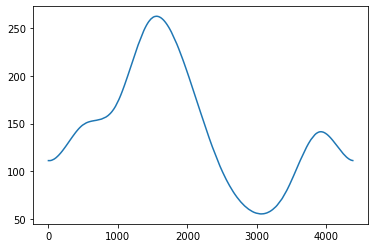

In [397]:
plt.plot(resultat["O2620010"])

In [241]:
from statsmodels.gam.api import CyclicCubicSplines, GLMGam

In [375]:
mesures_moyennes

,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,K0550010,K0690010,K0910050,...,H0800011,H0800012,H0810010,H1700010,H3930020,H4340020,H8100021,Mois,Jour,Heure
0,35.35,101.35,265.0,490.5,0.925,6.585,17.365,46.05,61.950,63.80,...,45.00,22.50,56.25,153.90,477.5,485.0,1036.5,1.0,1.0,0.0
1,38.35,98.60,275.0,499.5,0.930,6.530,17.565,44.75,62.005,63.30,...,45.10,22.55,56.70,153.80,476.5,484.0,1040.0,1.0,1.0,2.0
2,39.10,100.40,287.0,489.0,0.955,6.420,17.950,42.70,61.515,63.30,...,45.15,22.60,57.15,153.70,477.5,483.5,1043.0,1.0,1.0,4.0
3,35.65,102.10,294.5,467.5,0.975,6.420,17.500,39.70,61.520,63.30,...,45.10,22.65,57.65,153.55,477.5,481.5,1042.0,1.0,1.0,6.0
4,38.10,104.15,302.0,445.5,0.970,6.435,17.650,40.90,61.560,62.25,...,45.20,22.65,58.05,154.85,476.5,480.0,1051.0,1.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4376,27.80,96.45,273.5,414.5,1.150,7.675,27.750,74.40,99.400,164.50,...,50.50,28.95,73.35,210.50,522.0,544.5,1081.0,12.0,31.0,16.0
4377,31.75,95.05,274.0,429.0,1.135,7.505,27.250,74.65,98.750,164.50,...,50.80,29.05,73.45,209.00,524.5,546.0,1073.5,12.0,31.0,18.0
4378,35.70,98.10,279.5,453.0,1.125,7.335,26.800,76.90,97.150,164.00,...,51.25,29.10,73.45,208.00,526.5,549.0,1089.0,12.0,31.0,20.0
4379,42.00,98.00,279.0,481.5,1.115,7.225,26.500,80.75,96.850,162.00,...,51.80,29.25,73.55,208.00,526.0,550.5,1092.0,12.0,31.0,22.0


In [329]:
c

,O0200020,Date
0,35.35,0
1,38.35,1
2,39.10,2
3,35.65,3
4,38.10,4
...,...,...
4376,27.80,4376
4377,31.75,4377
4378,35.70,4378
4379,42.00,4379


In [331]:
spline = CyclicCubicSplines(X["O0200020"], df = [2])

In [334]:
compo = GLMGam.from_formula('O0200020~Date', X, smoother=spline)

In [335]:
compo

In [336]:
res = compo.fit()

In [337]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               O0200020   No. Observations:                 4381
Model:                         GLMGam   Df Residuals:                     4377
Model Family:                Gaussian   Df Model:                         3.00
Link Function:               identity   Scale:                          61.942
Method:                         PIRLS   Log-Likelihood:                -15253.
Date:                Fri, 31 Dec 2021   Deviance:                   2.7112e+05
Time:                        16:54:04   Pearson chi2:                 2.71e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -225.4256      2.000   -112.725      0.000    -229.345    -221.506
Date            0.0001   9.93e-05      1.215      0.224    -7.4e-05       0.000
O0200020_s0   243.8967      1.974    123.545      0.000     240.027     247.766
O0200020_s1   268.5443      1.795    149.591      0.000     265.026     272.063
===============================================================================
"""

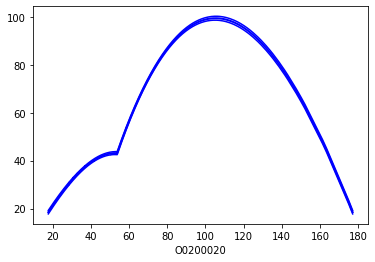

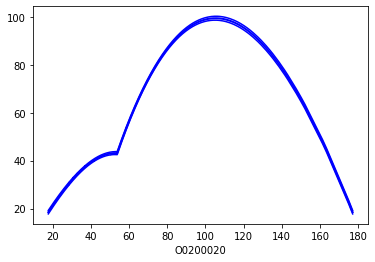

In [338]:
res.plot_partial(0)

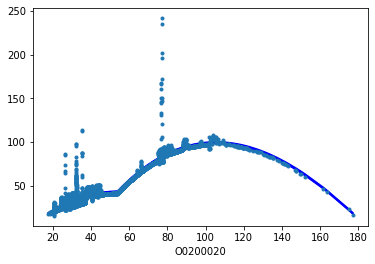

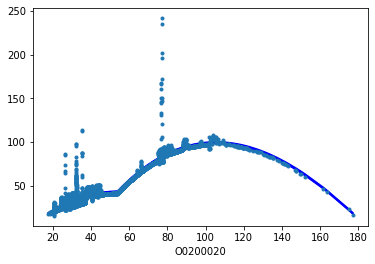

In [339]:
res.plot_partial(0, cpr=True)

In [299]:
res.partial_values(0)[1].shape

(4381,)

In [ ]:
curr_n_knots = 5
for code in liste_stations:
    X = mesures_moyennes[code]
    spline = SplineTransformer(n_knots=curr_n_knots,
                              knots = np.linspace(0, len(mesures_moyennes), curr_n_knots)[:, None],
                              extrapolation="periodic").fit_transform(X)
    #composante = spline.transform(X)
    break

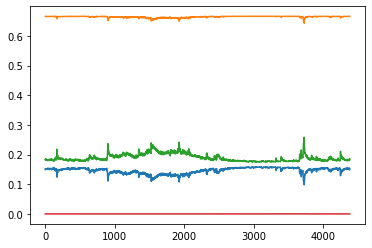

In [226]:
plt.plot(spline)

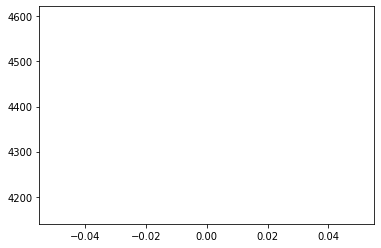

In [219]:
plt.plot(np.sum(spline))

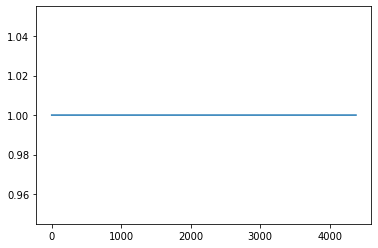

In [215]:
plt.plot(pd.DataFrame(spline).apply(lambda x: np.sum(x), axis = 1))

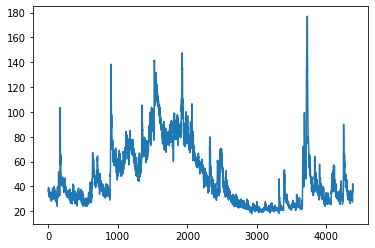

In [252]:
plt.plot(X)

In [89]:
len(mesures_moyennes)

4381

In [ ]:
for curr_split in range(9):
    curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
    curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
    
    dates_predictions = curr_test_Y[["Jour", "Mois", "Annee"]]
    liste_stations = list(stations_debit["Code station"])
    
    predictions_Y = fct_Modele_Naif(curr_test_X, dates_predictions, liste_stations)
    
    curr_scores = fct_scores_mse(curr_test_Y, predictions_Y, liste_stations)
    cv_scores["Split_" + str(curr_split)] = curr_scores["MSE"]
cv_scores

In [5]:
# Extend the test data into the future:
x_plot_ext = np.linspace(-1, 21, 200)
X_plot_ext = x_plot_ext[:, np.newaxis]

lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(color=["black", "tomato", "teal"])
ax.plot(x_plot_ext, g(x_plot_ext), linewidth=lw, label="ground truth")
ax.scatter(x_train, y_train, label="training points")

for transformer, label in [
    (SplineTransformer(degree=3, n_knots=10), "spline"),
    (
        SplineTransformer(
            degree=3,
            knots=np.linspace(0, 2 * np.pi, 10)[:, None],
            extrapolation="periodic",
        ),
        "periodic spline",
    ),
]:
    model = make_pipeline(transformer, Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot_ext = model.predict(X_plot_ext)

ax.legend()
fig.show()


array([[0.        ],
       [0.6981317 ],
       [1.3962634 ],
       [2.0943951 ],
       [2.7925268 ],
       [3.4906585 ],
       [4.1887902 ],
       [4.88692191],
       [5.58505361],
       [6.28318531]])